```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook evaluate simulation results against tide gauge 
measurements obtained from "Se havnivå" from Kartverket 

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


from matplotlib import animation, rc
from matplotlib import pyplot as plt

from IPython.display import clear_output

#Set large figure sizes
plt.rcParams["animation.html"] = "jshtml" #Javascript 
#plt.rcParams["animation.html"] = "html5" #mp4
#plt.rcParams["figure.dpi"] = 300 #highres movies/plots (nice for web)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import FBL, CTCS, KP07, CDKLM16, PlotHelper, Common, WindStress, IPythonMagic, OceanographicUtilities

In [3]:
%cuda_context_handler gpu_ctx

# Select area and result folder

In [4]:
## 
#case = 1 # Open waters in the Norwegian Sea
#case = 2 # Lofoten
case = 3 # The Norwegian Coast

casename = 'norwegian_sea_'


if case == 2:
    casename = 'lofoten_'
    
if case == 3:
    casename = 'complete_coast_'
    
folder = casename+datetime.datetime.now().strftime("%Y_%m_%d")

# Overrule the above folder name:
#folder = 'norwegian_sea_2019_10_09'
#folder = 'lofoten_2019_10_07'
#folder = 'sim_results/complete_coast_2019_10_09' # havahol desktop
#folder = 'complete_coast_2019_10_10' # havahol laptop
#folder = 'sim_results/complete_coast_2019_10_24'  # havahol desktop 10-minute cases
#folder = 'sim_results/lofoten_2019_10_27'         # havahol desktop 10-minute cases 
#folder = 'sim_results/complete_coast_2019_11_02/'  # havahol desktop 10-minute cases with new friction
#folder = 'sim_results/2019-11-09/complete_coast/'  # havahol desktop 10-minute cases with new bathymetry
#folder = 'sim_results/2019-11-10/lofoten_erode_land_1/' # havahol desktop 10-min Lofoten with new bath and erode 1
folder = 'sim_results/2019-11-10/complete_coast_erode_land_1/' # havahol desktop 10-min Lofoten with new bath and erode 1

assert(folder.find(casename[:-1]) > -1), 'folder does not start with casename!'


os.makedirs(folder, exist_ok=True)
print(folder)

sim_results/2019-11-10/complete_coast_erode_land_1/


# Misc helper functions

In [5]:
def printInfo(url):
    try:
        ncfile = Dataset(url)
        print("Variables")
        for var in ncfile.variables:
            print(var)

        print ("Attributes:")    
        for attr in ncfile.ncattrs():
            print(attr, ": ", ncfile.getncattr(attr))
    
    except Exception as e:
        raise e
        
    finally:
        ncfile.close()

In [6]:
def plotSolution(fig, 
                 eta, hu, hv, h, dx, dy, 
                 t, comment,
                 h_min=-1.5, h_max=1.5, 
                 uv_min=-0.05, uv_max=0.05, 
                 add_extra=False,
                 ax=None, sp=None):
    
    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    ny, nx = eta.shape
    domain_extent = [0, nx*dx, 0, ny*dy]
    
    x_plots = 3
    y_plots = 1
    if (add_extra == True):
        x_plots=3
        y_plots=2
    
    V_max = 3 * (uv_max-uv_min) / np.max(h)
    R_min = -V_max/2000
    R_max = V_max/2000

    if (ax is None):
        ax = [None]*x_plots*y_plots
        sp = [None]*x_plots*y_plots
        
        ax[0] = plt.subplot(y_plots, x_plots, 1)
        sp[0] = ax[0].imshow(eta, interpolation="none", origin='bottom', 
                             cmap=plt.cm.coolwarm, 
                             vmin=h_min, vmax=h_max, 
                             extent=domain_extent)
        plt.colorbar(sp[0], shrink=0.9)
        plt.axis('image')
        plt.title("$\eta{}$")
        
        ax[1] = plt.subplot(y_plots, x_plots, 2)
        sp[1] = ax[1].imshow(hu, interpolation="none", origin='bottom', 
                             cmap=plt.cm.coolwarm, 
                             vmin=uv_min, vmax=uv_max, 
                             extent=domain_extent)
        plt.colorbar(sp[1], shrink=0.9)
        plt.axis('image')
        plt.title("$hu$")

        ax[2] = plt.subplot(y_plots, x_plots, 3)
        sp[2] = ax[2].imshow(hv, interpolation="none", origin='bottom', 
                             cmap=plt.cm.coolwarm, 
                             vmin=uv_min, vmax=uv_max, 
                             extent=domain_extent)
        plt.colorbar(sp[2], shrink=0.9)
        plt.axis('image')
        plt.title("$hv$")

        if (add_extra == True):
            V = PlotHelper.genVelocity(h, hu, hv)
            ax[3] = plt.subplot(y_plots, x_plots, 4)
            sp[3] = ax[3].imshow(V, interpolation="none", origin='bottom', 
                               cmap=plt.cm.Oranges, 
                               vmin=0, vmax=V_max, 
                               extent=domain_extent)
            plt.colorbar(sp[3], shrink=0.9)
            plt.axis('image')
            plt.title("Particle velocity magnitude")

            R = PlotHelper.genColors(h, hu/dy, hv/dx, plt.cm.seismic, R_min, R_max)
            ax[4] = plt.subplot(y_plots, x_plots, 5)
            sp[4] = ax[4].imshow(R, interpolation="none", 
                               origin='bottom', 
                               extent=domain_extent)
            plt.colorbar(sp[4], shrink=0.9)
            plt.axis('image')
            plt.title("Vorticity magnitude")
            
    else:        
        #Update plots
        fig.sca(ax[0])
        sp[0].set_data(eta)
        
        fig.sca(ax[1])
        sp[1].set_data(hu)
        
        fig.sca(ax[2])
        sp[2].set_data(hv)
        
        if (add_extra == True):
            V = PlotHelper.genVelocity(h, hu, hv)
            fig.sca(ax[3])
            sp[3].set_data(V)

            R = PlotHelper.genColors(h, hu/dx, hv/dy, plt.cm.seismic, R_min, R_max)
            fig.sca(ax[4])
            sp[4].set_data(R)
    
    return ax, sp

# Inspect URL and select area

In [7]:
nordic4km_url = 'http://thredds.met.no/thredds/dodsC/fou-hi/nordic4km-1h/Nordic-4km_SURF_1h_avg_00.nc'
norkyst800_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

source_url = norkyst800_url

# Check for cached netcdf-file
filename = os.path.abspath(os.path.basename(source_url))
cache_folder='netcdf_cache'
cache_filename = os.path.abspath(os.path.join(cache_folder,
                                              os.path.basename(source_url)))

if (os.path.isfile(filename)):
    source_url = filename

elif (os.path.isfile(cache_filename)):
    source_url = cache_filename


#if source_url == norkyst800_url and os.path.exists(local_norkyst800_url_havahol):
#    source_url = local_norkyst800_url_havahol
    
print(source_url)

/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/realisticSimulations/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc


In [8]:
try:
    ncfile = Dataset(source_url)
    H_full = np.array(ncfile.variables['h'])
    angle = np.array(ncfile.variables['angle'])
    print(H_full.shape)
    lat = np.array(ncfile.variables["lat"])
    lon = np.array(ncfile.variables["lon"])
    landmask = ncfile.variables['zeta'][0,:,:].mask
except Exception as e:
    raise e

finally:
    ncfile.close()
    
    

(902, 2602)


<class 'numpy.ndarray'> True False


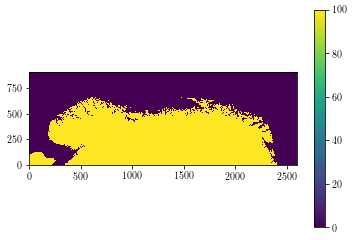

In [9]:
print(type(landmask), landmask.max(), landmask.min())
plt.imshow(landmask*100, origin='lower')
plt.colorbar()

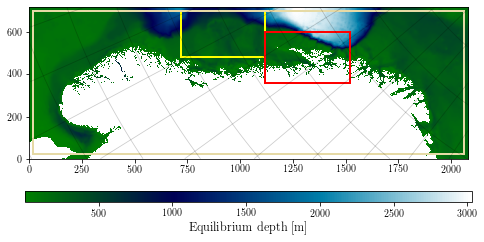

In [10]:
##### 
case2_x0 = 1400
case2_x1 = int(case2_x0 + 500)
case2_y0 = 450
case2_y1 = int(case2_y0 + 300)

#x0 = 1650
#x1 = int(x0 + 100)
#y0 = 450
#y1 = int(y0 + 200)

case1_x0 = 900
case1_x1 = 1400
case1_y0 = 600
case1_y1 = 875


case3_x0 = 25
case3_x1 = 2575
case3_y0 = 25
case3_y1 = 875


def plot_map(show_cases=True, stars=None, annotations=[], save_filename=None):
    land_value = H_full.min()
    (full_ny, full_nx) = H_full.shape

    # Makes sure axis are in km (assuming equidistant 800x800m grid)
    extent=np.array([0, full_nx*0.8, 0, full_ny*0.8])


    fig, ax = plt.subplots(figsize=(8,4))

    # Land and bathymetry
    land = np.ma.masked_where(H_full == land_value, H_full)
    im = plt.imshow(land, interpolation="None", origin='lower', cmap='ocean',
               extent=extent)

    cbar = fig.colorbar(im, orientation='horizontal', aspect=40)
    cbar.set_label('Equilibrium depth [m]', size=12.5)
    
    if stars is not None:
        for star in stars:
            plt.scatter(star[1]*0.8, star[0]*0.8, s=100, c='r', marker='*')


    if show_cases:
        # Case boxes
        fig.gca().fill(np.array([case1_x0, case1_x0, case1_x1, case1_x1])*0.8, 
                       np.array([case1_y0, case1_y1, case1_y1, case1_y0])*0.8, 
                       fill=False, linestyle='-', linewidth=2, color='yellow')
        fig.gca().fill(np.array([case2_x0, case2_x0, case2_x1, case2_x1])*0.8, 
                       np.array([case2_y0, case2_y1, case2_y1, case2_y0])*0.8, 
                       fill=False, linestyle='-', linewidth=2, color='red')

        fig.gca().fill(np.array([case3_x0, case3_x0, case3_x1, case3_x1])*0.8, 
                       np.array([case3_y0, case3_y1, case3_y1, case3_y0])*0.8, 
                       fill=False, linestyle='-', linewidth=2, color='xkcd:beige')

    # Lat-lon lines
    plt.contour(lon, levels = np.arange(0, 40, 4), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
    plt.contour(lat, levels = np.arange(56,77, 2), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
    
    for annotation in annotations:
        # Must be on the format [[label_1, xy_pos_1], [label_2, xy_pos_2],...]
        ax.annotate(annotation[0], xy=annotation[1])
    
    if save_filename is not None:
        plt.savefig(save_filename + '.pdf', bbox_inches='tight')
        plt.savefig(save_filename + '.png', bbox_inches='tight')
    
plot_map()



In [11]:
## Select case

x0 = case1_x0
x1 = case1_x1
y0 = case1_y0
y1 = case1_y1

if case == 2:
    x0 = case2_x0
    x1 = case2_x1
    y0 = case2_y0
    y1 = case2_y1
    print('using the Lofoten case')

elif case == 3:
    x0 = case3_x0
    x1 = case3_x1
    y0 = case3_y0
    y1 = case3_y1
    print('using the complete coast case')

else:

    print('using Norwegian Sea area')


using the complete coast case


# Read a reference water level file


argmin:  1403998
site_y, site_x:  (539, 1520)
distances.shape (902, 2602)


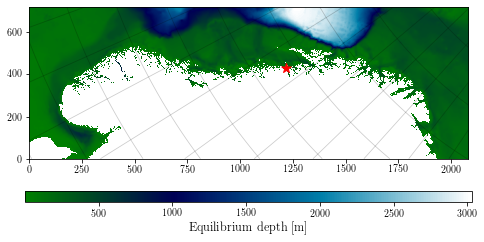

In [12]:
#reference_file = os.path.join('reference_data/bodo_msl.txt')
reference_file = os.path.join('reference_data', 'bodo_nn2000.txt')

def read_reference_file(filename):
    headers = ['datetime', 'observed', 'predicted']
    
    df = pd.read_csv(filename, delim_whitespace=True, skiprows=14, header=None, names=headers) # header=headers)
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    return df


def get_meta_data(filename):
    sitename = None
    lat = None
    lon = None
    with open(filename) as file:
        for line in file:
            line = str(line)
    
            # Find simulator
            #match = re.match('#Site name':, line)
            if line.startswith('#Site name:'):
                sitename = line.replace('#Site name:', '').strip()
                if sitename.startswith('BOD'):
                    sitename = 'BODØ'
                elif sitename.startswith('HONNING'):
                    sitename = 'HONNINGSVÅG'
            elif line.startswith('#Latitude:'):
                lat = np.float(line.replace('#Latitude:','').strip())
            elif line.startswith('#Longitude:'):
                lon = np.float(line.replace('#Longitude:','').strip())
    return sitename, lat, lon


def get_cell_location(lat, lon, site_lat, site_lon, landmask):
    ny, nx = lat.shape
    search_nx = np.floor(nx/2)
    search_ny = np.floor(ny/2)
    
    distances = (lat-site_lat)**2 + (lon-site_lon)**2 + landmask*1000
    ref_site_y, ref_site_x = np.unravel_index(distances.argmin(), distances.shape)
    print('argmin: ', np.argmin(distances))
    print('site_y, site_x: ', (ref_site_y, ref_site_x))
    print('distances.shape', distances.shape)
    
    # Location in our simulation with original resolution:
    orig_site_y = ref_site_y - y0
    orig_site_x = ref_site_x - x0
    
    # Location in our simulation with low resolution:
    low_site_y = np.int(np.floor(orig_site_y/2))
    low_site_x = np.int(np.floor(orig_site_x/2))
    
    # Location in our simulation with high resolution:
    high_site_y = orig_site_y*2
    high_site_x = orig_site_x*2
    
    # Move towards the lowest value in an landmask free X:
    distances = (lat-site_lat)**2 + (lon-site_lon)**2
    # d(own), u(p), l(eft), r(ight)
    dl = distances[ref_site_y-1, ref_site_x-1]
    dr = distances[ref_site_y-1, ref_site_x+1]
    ul = distances[ref_site_y+1, ref_site_x-1]
    ur = distances[ref_site_y+1, ref_site_x+1]
    
    direction = min(dl, dr, ul, ur)
    if direction == dr or direction == ur:
        high_site_x = high_site_x + 1
    if direction == ur or direction == ul:
        high_site_y = high_site_y + 1
    
    
    
    #dlocy_dlat = 2*(lat-)
    
    
    return (ref_site_y, ref_site_x), (orig_site_y, orig_site_x), \
           (low_site_y, low_site_x), (high_site_y, high_site_x)
    
    
df = read_reference_file(reference_file)
sitename, site_lat, site_lon = get_meta_data(reference_file)
site_loc_ref, site_loc_orig, site_loc_low, site_loc_high = get_cell_location(lat, lon, 
                                                                             site_lat, site_lon, 
                                                                             landmask)
plot_map(show_cases=False, stars=[site_loc_ref])
#plot_df(df)
#pf

sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_original.nc
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_lowres.nc
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_highres.nc


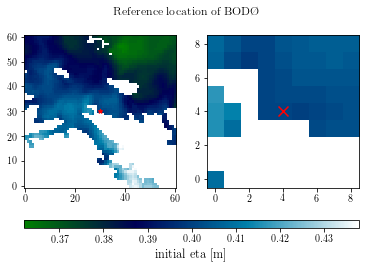

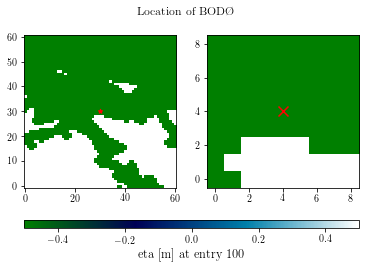

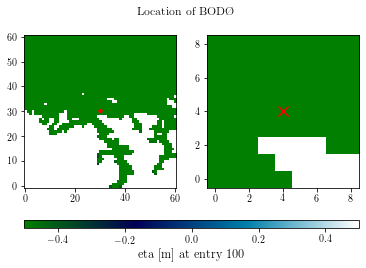

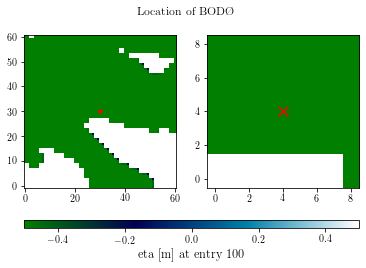

In [30]:
def get_simulated_sea_level_values(casename, site_loc, sitename, show_area=True, plot_time=0):
    sim_result_file = os.path.join(folder, casename)
        
    try:
        ncfile = Dataset(sim_result_file)
        t = ncfile.variables['time'][:]

        simulated_sea_level = ncfile.variables['eta'][:, site_loc[0], site_loc[1]]
        plot_eta = ncfile.variables['eta'][plot_time, :, :]
    except Exception as e:
        raise e
    finally:
        ncfile.close()

    #simulated_sea_level = eta[:, site_loc[0], site_loc[1]]
    
    #print(simulated_sea_level)
    print(sim_result_file)
    
    if show_area:
        eta_orig_local = plot_eta[site_loc[0]-30:site_loc[0]+31, 
                                  site_loc[1]-30:site_loc[1]+31]
        
        fig, axes = plt.subplots(nrows=1, ncols=2)
        
        
        eta_min = -0.5 #eta_orig_local.min()
        eta_max =  0.5 #eta_orig_local.max()
        if plot_time == -1:
            eta_min = eta_orig_local.min()
            eta_max = eta_orig_local.max()
            
        
        im = axes[0].imshow(eta_orig_local, interpolation="None", origin='lower', 
                            cmap='ocean', vmin=eta_min, vmax=eta_max)

        
        axes[0].scatter(30, 30, s=20, c='red', marker='*')

        axes[1].imshow(plot_eta[site_loc[0]-4:site_loc[0]+5, 
                                site_loc[1]-4:site_loc[1]+5], 
                       origin='lower', interpolation='none', 
                       cmap='ocean', vmin=eta_min, vmax=eta_max)
        axes[1].scatter(4, 4, s=100, c='r', marker='x')

        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), 
                            orientation='horizontal', aspect=40)
        if plot_time == 0:
            cbar.set_label('Initial eta [m] ('+casename.replace('_','-')+')', size=12.5)
        else:
            cbar.set_label('eta [m] at entry ' + str(plot_time), size=12.5)
        plt.suptitle('Location of ' + sitename)
    
        #print(eta[plot_time, site_loc[0]-4:site_loc[0]+5, site_loc[1]-4:site_loc[1]+5])
    
    return simulated_sea_level, t/3600

def get_norkyst_sea_level_values(source_url, site_loc, sitename, show_area=True):
    
    try:
        ncfile = Dataset(source_url)
        t = ncfile.variables['time'][:]

        eta = ncfile.variables['zeta'][0,:,:]
        landmask = ncfile.variables['zeta'][0,:,:].mask
        reference_sea_level = ncfile.variables['zeta'][:, site_loc[0], site_loc[1]]
    except Exception as e:
        raise e
    finally:
        ncfile.close()
        
    #print('eta.shape: ', eta.shape)
    #reference_sea_level = eta[:, site_loc[0], site_loc[1]]
    #print(simulated_sea_level)

    #print('len(t): ', len(t))
    #print('eta.shape:',eta.shape)
    #print('type(eta): ', type(eta))
    
    if show_area:
        
        eta_orig_local = eta[site_loc[0]-30:site_loc[0]+31, 
                             site_loc[1]-30:site_loc[1]+31]
        
        fig, axes = plt.subplots(nrows=1, ncols=2)
        
        
        eta_min = eta_orig_local.min()
        eta_max = eta_orig_local.max()
        
        im = axes[0].imshow(eta_orig_local, interpolation="None", origin='lower', 
                            cmap='ocean', vmin=eta_min, vmax=eta_max)

        
        axes[0].scatter(30, 30, s=20, c='red', marker='*')

        axes[1].imshow(eta[site_loc[0]-4:site_loc[0]+5, site_loc[1]-4:site_loc[1]+5], 
                       origin='lower', interpolation='none', 
                       cmap='ocean', vmin=eta_min, vmax=eta_max)
        axes[1].scatter(4, 4, s=100, c='r', marker='x')

        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), 
                            orientation='horizontal', aspect=40)
        cbar.set_label('initial eta [m]', size=12.5)
        plt.suptitle('Reference location of ' + sitename)

        #print(eta[0, site_loc[0]-4:site_loc[0]+5, site_loc[1]-4:site_loc[1]+5])
        
    return reference_sea_level
    
reference_sea_level_norkyst = get_norkyst_sea_level_values(source_url, site_loc_ref, sitename)

simulated_sea_level_orig, simulated_t_orig = get_simulated_sea_level_values(casename + 'original.nc', 
                                                                            site_loc_orig, sitename,
                                                                            plot_time=100)

simulated_sea_level_lowres, simulated_t_lowres = get_simulated_sea_level_values(casename + 'lowres.nc', 
                                                                                site_loc_low, sitename,
                                                                                plot_time=100)

simulated_sea_level_highres, simulated_t_highres = get_simulated_sea_level_values(casename + 'highres.nc', 
                                                                                  site_loc_high, sitename,
                                                                                  plot_time=100)


144
2019-07-16 01:00:00+02:00


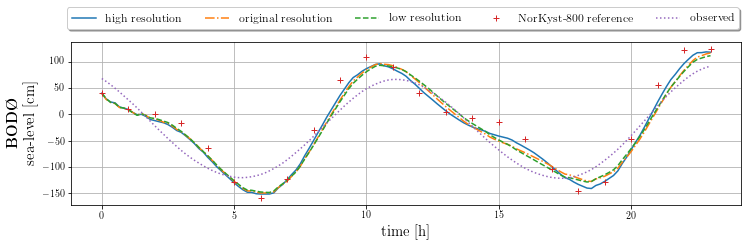

In [14]:
def plot_df(df, sitename=None, 
            simulated_values_orig=None, simulated_t_orig=None,
            simulated_values_lowres=None, simulated_t_lowres=None,
            simulated_values_highres=None, simulated_t_highres=None,
            norkyst_values=None, ref_name=None):
    num_vals_in_a_day = 6*24
    start_index = 6
    end_index = num_vals_in_a_day + start_index-5
    print(num_vals_in_a_day)
    
    fig = plt.figure(figsize=(12,3))
    
    # Get time into decimal hours since the start of simulation
    print(df.iloc[0]['datetime'])
    time = pd.to_numeric(df.iloc[start_index:end_index]['datetime'] - df.iloc[start_index][0])/1e9/3600
    
    if simulated_values_highres is not None:
        if simulated_t_highres is None:
            simulated_t_highres = np.arange(24)
        symbol = '-'
        if len(simulated_values_highres) < 25:
            symbol = '*'
        plt.plot(simulated_t_highres, simulated_values_highres*100, symbol, label='high resolution')
        
    if simulated_values_orig is not None:
        if simulated_t_orig is None:
            simulated_t_orig = np.arange(24)
        symbol = '-.'
        if len(simulated_values_orig) < 25:
            symbol = '*'
        plt.plot(simulated_t_orig, simulated_values_orig*100, symbol, label='original resolution')
    
    if simulated_values_lowres is not None:
        if simulated_t_lowres is None:
            simulated_t_osimulated_t_lowresrig = np.arange(24)
        symbol = '--'
        if len(simulated_values_lowres) < 25:
            symbol = '*'
        plt.plot(simulated_t_lowres, simulated_values_lowres*100, symbol, label='low resolution')
    
    
    if norkyst_values is not None:
        plt.plot(norkyst_values*100, '+', label='NorKyst-800 reference')
    
    plt.plot(time, df.iloc[start_index:end_index]['observed'], ':', label='observed')
    #plt.plot(time, df.iloc[start_index:end_index]['predicted'], '--', label='predicted')
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.495, 1.25),
               fancybox=True, shadow=True, ncol=5, fontsize=12)
    plt.xlabel(r'time [h]', fontsize=15)
    if sitename:
        plt.ylabel(r'\textbf{'+sitename+'} \n sea-level [cm]', fontsize=15)
    else:
        plt.ylabel(r'sea-level [cm]', fontsize=15)

    plt.grid()
    #if sitename is not None:
    #    plt.title(sitename)
    #print(time[0].hour)

    
    if ref_name is not None:
        plt.savefig(ref_name.replace('.txt', '.pdf'), bbox_inches='tight')
        plt.savefig(ref_name.replace('.txt', '.png'), bbox_inches='tight')


plot_df(df, sitename, 
        simulated_values_orig=simulated_sea_level_orig, simulated_t_orig=simulated_t_orig,
        simulated_values_lowres=simulated_sea_level_lowres,   simulated_t_lowres=simulated_t_lowres,
        simulated_values_highres=simulated_sea_level_highres, simulated_t_highres=simulated_t_highres,
        norkyst_values=reference_sea_level_norkyst,
        ref_name='reference_data/test.txt')

### Plot local area around star

# Make reference plots for all interesting locations

In [15]:
def make_validation_plot(reference_file, location_time=0):
    
    # Read reference 
    df = read_reference_file(reference_file)
    sitename, site_lat, site_lon = get_meta_data(reference_file)
    
    site_loc_ref, site_loc_orig, site_loc_low, site_loc_high = get_cell_location(lat, lon, 
                                                                                 site_lat, site_lon, 
                                                                                 landmask)
    
    simulated_sea_level_orig,    orig_t = get_simulated_sea_level_values(casename + 'original.nc', 
                                                                         site_loc_orig, sitename,
                                                                         plot_time=location_time)
    simulated_sea_level_lowres,  low_t  = get_simulated_sea_level_values(casename + 'lowres.nc', 
                                                                         site_loc_low, sitename,
                                                                         plot_time=location_time)
    simulated_sea_level_highres, high_t = get_simulated_sea_level_values(casename + 'highres.nc', 
                                                                         site_loc_high, sitename,
                                                                         plot_time=location_time)
    reference_sea_level_norkyst = get_norkyst_sea_level_values(source_url, site_loc_ref, sitename)
    
    plot_df(df, sitename, 
            simulated_values_orig   =simulated_sea_level_orig,    simulated_t_orig   =orig_t,
            simulated_values_lowres =simulated_sea_level_lowres,  simulated_t_lowres =low_t,
            simulated_values_highres=simulated_sea_level_highres, simulated_t_highres=high_t,
            norkyst_values=reference_sea_level_norkyst,
            ref_name=reference_file)
    
    
    

argmin:  1403998
site_y, site_x:  (539, 1520)
distances.shape (902, 2602)
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_original.nc
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_lowres.nc
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_highres.nc
144
2019-07-16 01:00:00+02:00


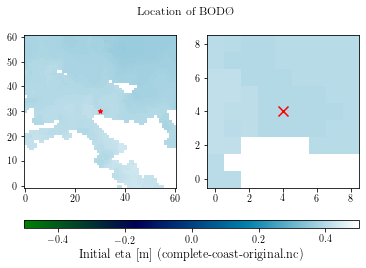

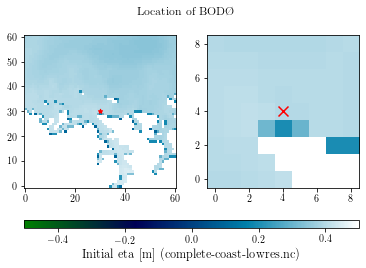

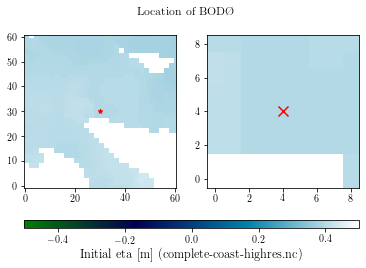

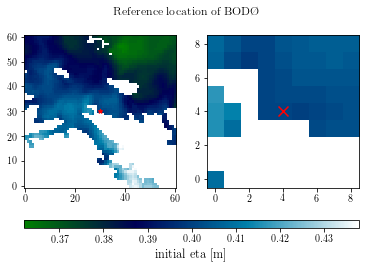

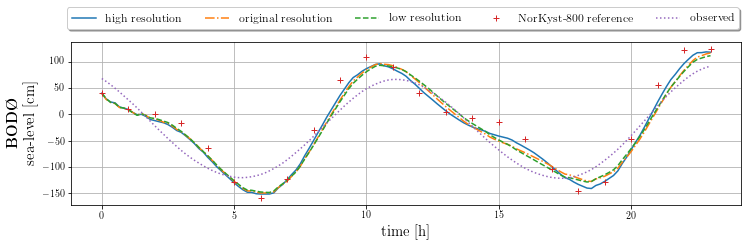

In [16]:
make_validation_plot(os.path.join('reference_data','bodo_nn2000.txt'))

argmin:  1418518
site_y, site_x:  (545, 428)
distances.shape (902, 2602)
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_original.nc
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_lowres.nc
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_highres.nc
144
2019-07-16 01:00:00+02:00


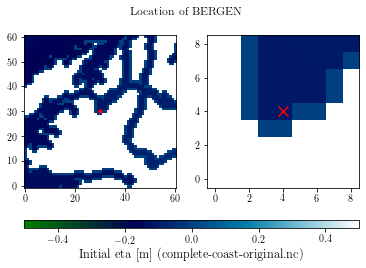

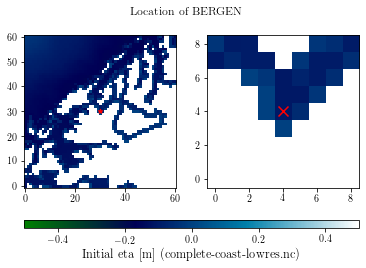

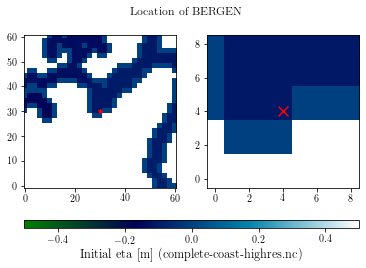

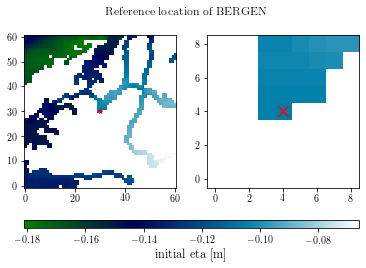

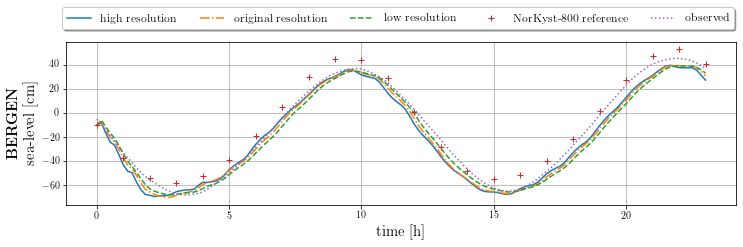

In [17]:
make_validation_plot(os.path.join('reference_data','bergen_nn2000.txt'))

argmin:  471506
site_y, site_x:  (181, 544)
distances.shape (902, 2602)
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_original.nc
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_lowres.nc
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_highres.nc
144
2019-07-16 01:00:00+02:00


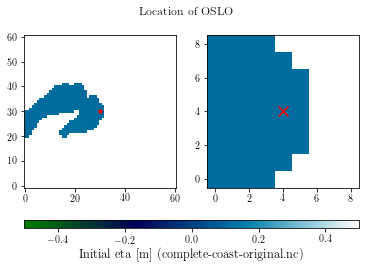

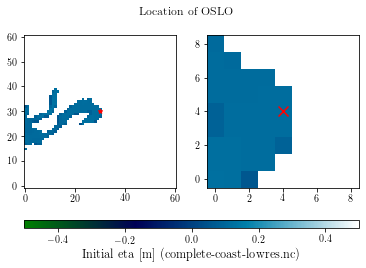

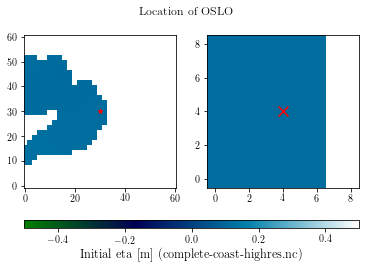

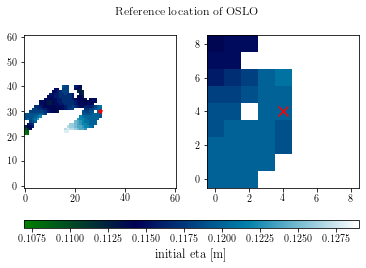

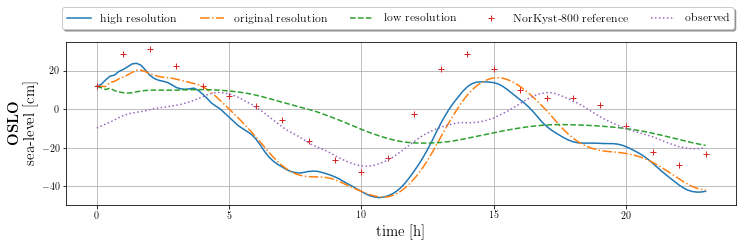

In [18]:
make_validation_plot(os.path.join('reference_data','oslo_nn2000.txt'))

argmin:  1128920
site_y, site_x:  (433, 2254)
distances.shape (902, 2602)
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_original.nc
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_lowres.nc
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_highres.nc
144
2019-07-16 01:00:00+02:00


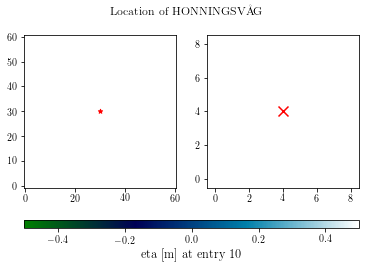

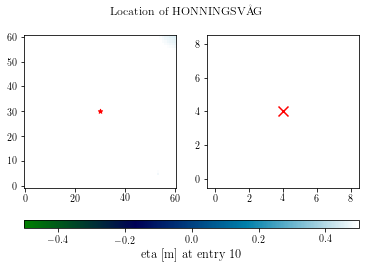

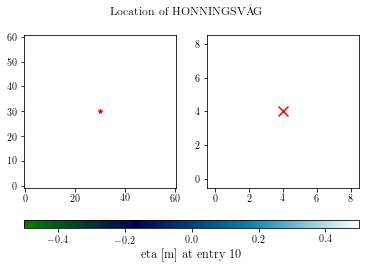

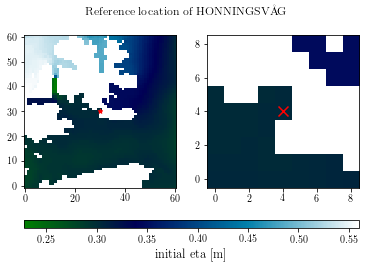

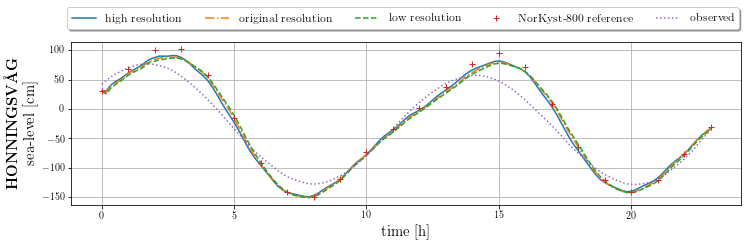

In [19]:
make_validation_plot(os.path.join('reference_data','honningsvaag_nn2000.txt'), location_time=10)

argmin:  655904
site_y, site_x:  (252, 200)
distances.shape (902, 2602)
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_original.nc
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_lowres.nc
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_highres.nc
144
2019-07-16 01:00:00+02:00


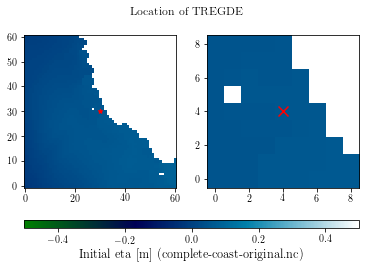

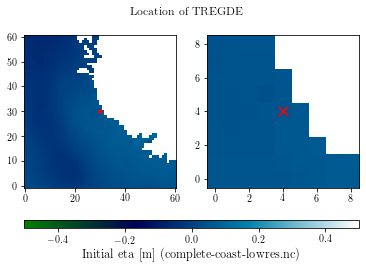

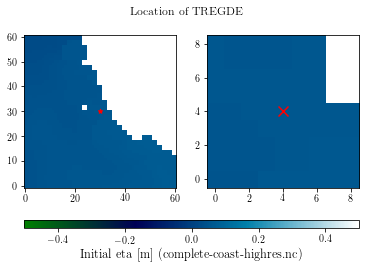

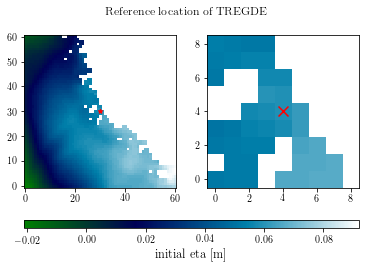

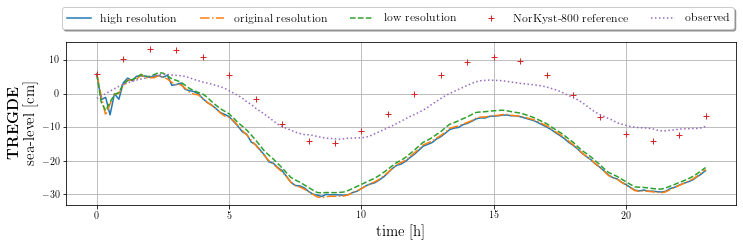

In [20]:
make_validation_plot(os.path.join('reference_data','tregde_nn2000.txt'))

argmin:  1307937
site_y, site_x:  (502, 1733)
distances.shape (902, 2602)
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_original.nc
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_lowres.nc
sim_results/2019-11-10/complete_coast_erode_land_1/complete_coast_highres.nc
144
2019-07-16 01:00:00+02:00


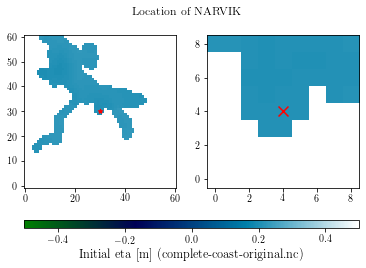

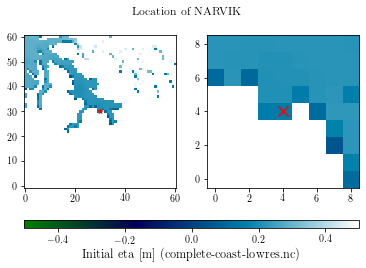

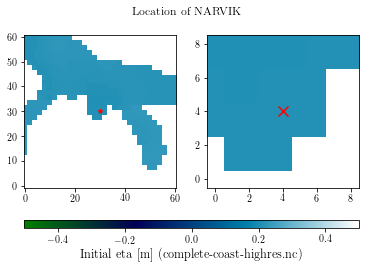

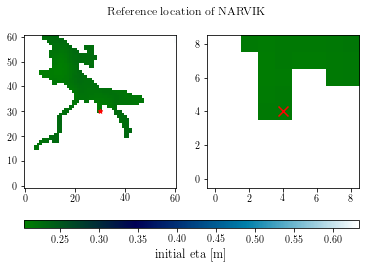

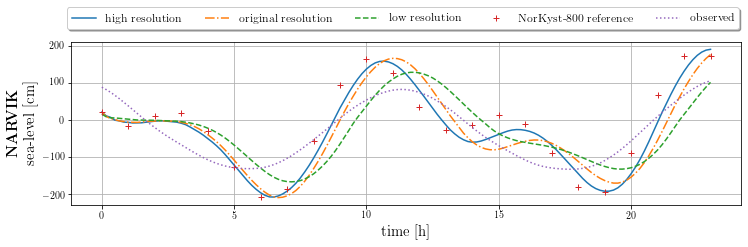

In [21]:
make_validation_plot(os.path.join('reference_data','narvik_nn2000.txt'))

# Show locations on the map

argmin:  471506
site_y, site_x:  (181, 544)
distances.shape (902, 2602)
argmin:  1418518
site_y, site_x:  (545, 428)
distances.shape (902, 2602)
argmin:  1403998
site_y, site_x:  (539, 1520)
distances.shape (902, 2602)
argmin:  1307937
site_y, site_x:  (502, 1733)
distances.shape (902, 2602)
argmin:  1128920
site_y, site_x:  (433, 2254)
distances.shape (902, 2602)


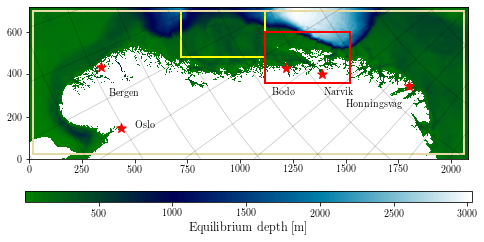

In [22]:

def getRefLocation(reference_file):
    sitename, site_lat, site_lon = get_meta_data(reference_file)    
    site_loc_ref, site_loc_orig, site_loc_low, site_loc_high = get_cell_location(lat, lon, 
                                                                                 site_lat, site_lon, 
                                                                                 landmask)
    return site_loc_ref

locs = [getRefLocation(os.path.join('reference_data','oslo_nn2000.txt')),
        getRefLocation(os.path.join('reference_data','bergen_nn2000.txt')),
        getRefLocation(os.path.join('reference_data','bodo_nn2000.txt')),
        getRefLocation(os.path.join('reference_data','narvik_nn2000.txt')),
        getRefLocation(os.path.join('reference_data','honningsvaag_nn2000.txt'))]

# annotations = [label, (x, y)]
annotations = [['Oslo', (500, 150)],
               ['Bergen', (380, 300)],
               ['Bodø', (1150, 300)],
               ['Narvik', (1400, 300)],
               ['Honningsvåg', (1500, 250)]]


plot_map(show_cases=True, 
         stars=locs, annotations=annotations, 
         save_filename='reference_data/cases_locations')


In [23]:
folder

'sim_results/2019-11-10/complete_coast_erode_land_1/'

In [26]:
128**2

16384